<a href="https://colab.research.google.com/github/Pikarz/tirocinio_infostud/blob/main/models/OC_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisi dati infostud (phoenixws_requests_average) attraverso il modello OC-SVM

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
### rende oc-svm più efficiente computazionalmente
!pip install scikit-learn-intelex
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Training e plotting di diversi modelli OC-SVM: funzioni ```train_multiple_ocsvm``` e ```plot_decision_boundary```
In questa versione, trovandomi in un ambiente supervised, ho aggiornato le funzioni cosicché mostrino i valori F1, precision e recall.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score


def calculate_metrics(true_labels, predicted_labels):
    true_positive = sum(1 for t, p in zip(true_labels, predicted_labels) if t and p)
    false_positive = sum(1 for t, p in zip(true_labels, predicted_labels) if not t and p)
    false_negative = sum(1 for t, p in zip(true_labels, predicted_labels) if t and not p)

    if true_positive + false_positive == 0:
        precision = 0
    else:
        precision = true_positive / (true_positive + false_positive)

    if true_positive + false_negative == 0:
        recall = 0
    else:
        recall = true_positive / (true_positive + false_negative)

    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1

def plot_label_differences_2d(test_data, true_labels, predicted_labels):
    # Perform PCA to reduce dimensionality to 2 dimensions
    pca = PCA(n_components=2)
    test_data_2d = pca.fit_transform(test_data)

    # Create lists to store colors for different categories
    colors = []

    for true_label, pred_label in zip(true_labels, predicted_labels):
        if true_label == 1 and pred_label == 1:
            # True Positive (Green)
            colors.append('g')
        elif true_label == 0 and pred_label == 1:
            # False Positive (Red)
            colors.append('r')
        elif true_label == 1 and pred_label == 0:
            # False Negative (Purple)
            colors.append('purple')
        elif true_label == 0 and pred_label == 0:
            # True Negative (Blue)
            colors.append('blue')
        else:
            colors.append('gray')  # Handle any other cases with a gray color

    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(test_data_2d[:, 0], test_data_2d[:, 1], c=colors, marker='o')

    # Add labels and legend
    plt.xlabel('Primo componente principale')
    plt.ylabel('Secondo componente principale')

    # Create custom legend entries
    legend_entries = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=10, label='True Positive (TP)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='False Positive (FP)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label='False Negative (FN)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='True Negative (TN)')
    ]

    plt.legend(handles=legend_entries, loc='best')
    plt.title('True vs. Predicted Labels')
    plt.show()



def grid_search_ocsvm(train_data, valid_data, true_valid_labels, params):
    best_f1_score = 0.0
    best_hyperparams = None

    for kernel in params['kernel']:
        for nu in params['nu']:
            hyperparams = "nu: " + str(nu) + ", kernel: " + kernel
            print(hyperparams)

            ocsvm = OneClassSVM(nu=nu, kernel=kernel)
            ocsvm.fit(train_data)

            predicted_labels = ocsvm.predict(valid_data)
            predicted_labels[predicted_labels==-1] = 0
            predicted_labels_bool = predicted_labels.astype(bool)
            precision, recall, f1 = calculate_metrics(true_valid_labels, predicted_labels_bool)
            print("Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}".format(precision, recall, f1))
            print('-' * 30)

            plot_label_differences_2d(valid_data, true_valid_labels.ravel(), predicted_labels_bool)

            if f1 > best_f1_score:
                best_f1_score = f1
                best_hyperparams = hyperparams

    print("Best F1 Score:", best_f1_score)
    print("Best Hyperparameters:", best_hyperparams)

    return best_hyperparams

In [ ]:
def calculate_anomaly_percentage(ground_truth):
    num_anomalies = np.sum(ground_truth)
    total_samples = len(ground_truth)
    anomaly_percentage = (num_anomalies / total_samples) * 100
    return anomaly_percentage

# data preparation

In [ ]:
dataset_path = './drive/My Drive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/average_dataset/phoenixws_average_2020-06-13.csv'
labels_path = './drive/My Drive/Uni/Terzo Anno/Tirocinio/Dataset Infostud/average_dataset/phoenixws_average_2020-06-13_gt.csv'

columns = ['phoenixws_average_'+str(i) for i in range(12)]
average_df = pd.read_csv(dataset_path, names=columns)
average_df.index.name = 'time'

In [ ]:
# normalizzazione
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
average_df_normalized = pd.DataFrame(scaler.fit_transform(average_df), index=average_df.index, columns=average_df.columns)

In [ ]:
average_df_normalized.fillna(average_df_normalized.mean(), inplace=True)
df_ready = average_df_normalized

In [ ]:
# estrazione

columns = ['label']
labels_df = pd.read_csv(labels_path, names=columns)
labels_df.index.name = 'time'
#common_indices = labels_df.index.isin(average_df_normalized.index)
#labels_df = labels_df[common_indices]
labels_df

label
time        
0      False
1      False
2      False
3      False
4      False
...      ...
48332  False
48333  False
48334  False
48335  False
48336  False

[48337 rows x 1 columns]

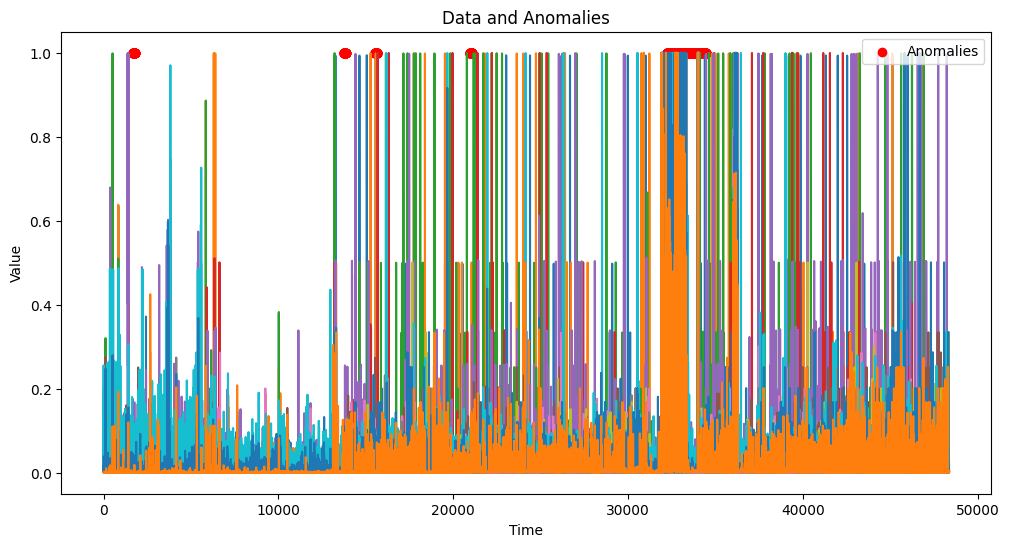

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

merged_df = pd.merge(average_df_normalized, labels_df, on="time", how="inner")
highlighted_points = merged_df[merged_df["label"] == 1]
plt.figure(figsize=(12, 6))
plt.plot(average_df_normalized)
plt.scatter(highlighted_points.index, highlighted_points["label"], color="red", label="Anomalies")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Data and Anomalies")
plt.show()

# training

In [ ]:
import math

train_split_index = 0.50
valid_split_index = 0.182
#test_size = 0.235

training_end = int(math.floor(df_ready.shape[0]*train_split_index))
train_set = df_ready.head(training_end).values
train_labels = labels_df.head(training_end).astype(int).values

validation_end = training_end + int(math.floor(df_ready.shape[0]*valid_split_index))
valid_set = df_ready.iloc[training_end:validation_end].values
valid_labels = labels_df.iloc[training_end:validation_end].astype(int).values

test_set = df_ready.iloc[validation_end:].values
test_labels = labels_df.iloc[validation_end:].astype(int).values

In [ ]:
print(f"Train labels anomaly perc: {calculate_anomaly_percentage(train_labels)}")
print(f"Valid labels anomaly perc: {calculate_anomaly_percentage(valid_labels)}")
print(f"Test labels anomaly perc: {calculate_anomaly_percentage(test_labels)}")

Train labels anomaly perc: 2.015061238000662
Valid labels anomaly perc: 8.605206320336478
Test labels anomaly perc: 9.595368201925579


nu: 0.03, kernel: linear
Precision: 0.0891, Recall: 1.0000, F1 Score: 0.1636
------------------------------


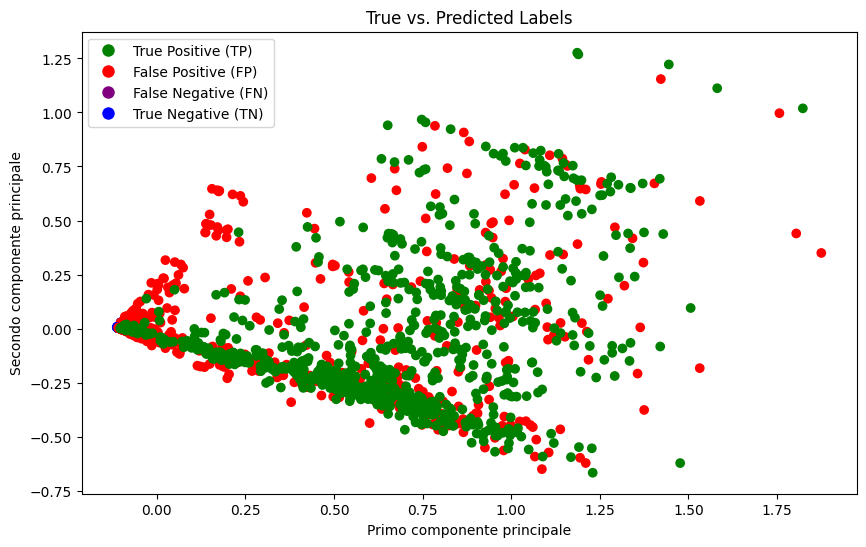

nu: 0.1, kernel: linear
Precision: 0.0970, Recall: 1.0000, F1 Score: 0.1769
------------------------------


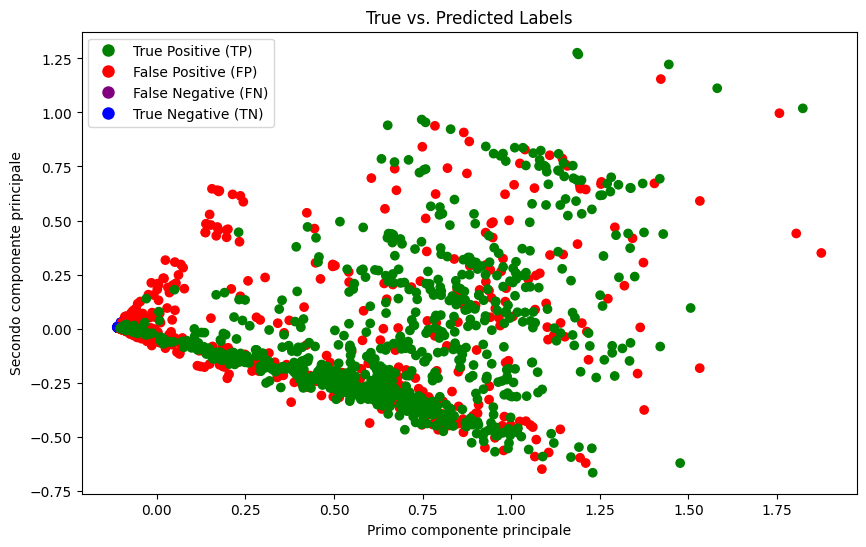

nu: 0.25, kernel: linear
Precision: 0.1209, Recall: 0.9987, F1 Score: 0.2156
------------------------------


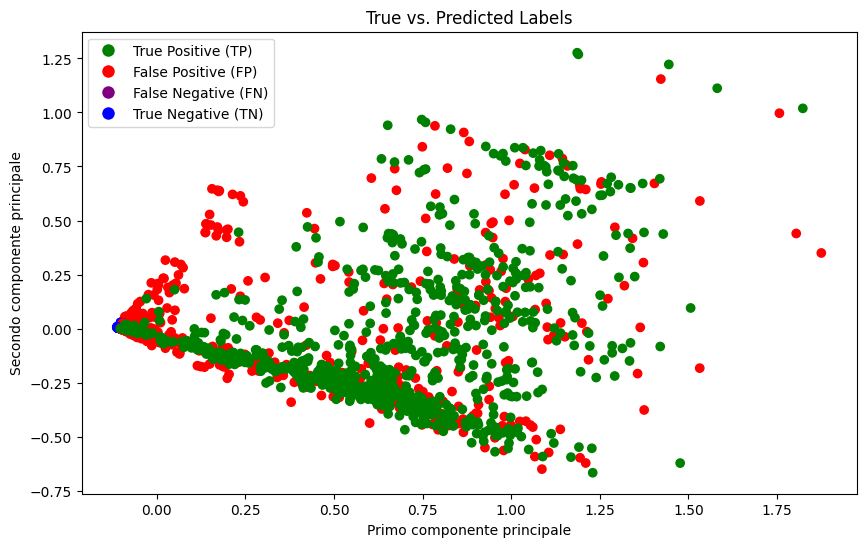

nu: 0.5, kernel: linear
Precision: 0.1943, Recall: 0.9947, F1 Score: 0.3251
------------------------------


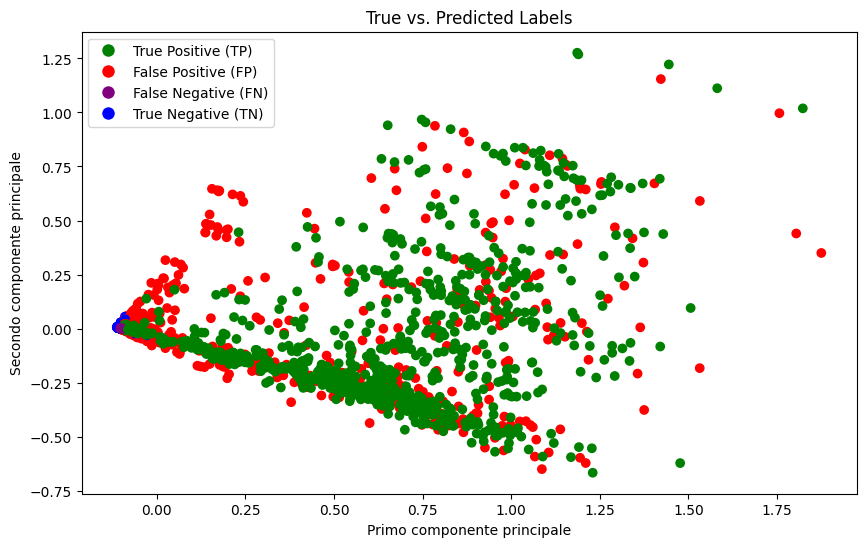

nu: 0.9, kernel: linear
Precision: 0.5728, Recall: 0.9564, F1 Score: 0.7165
------------------------------


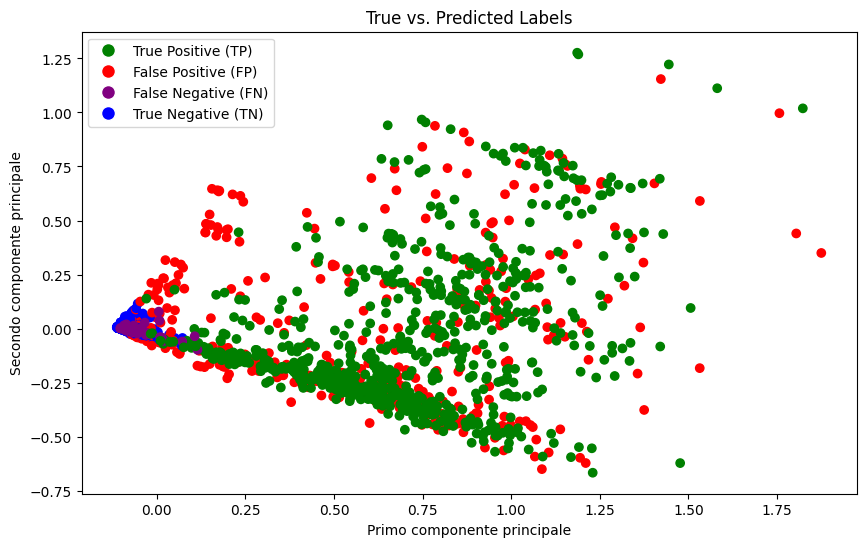

nu: 0.03, kernel: poly
Precision: 0.0893, Recall: 1.0000, F1 Score: 0.1639
------------------------------


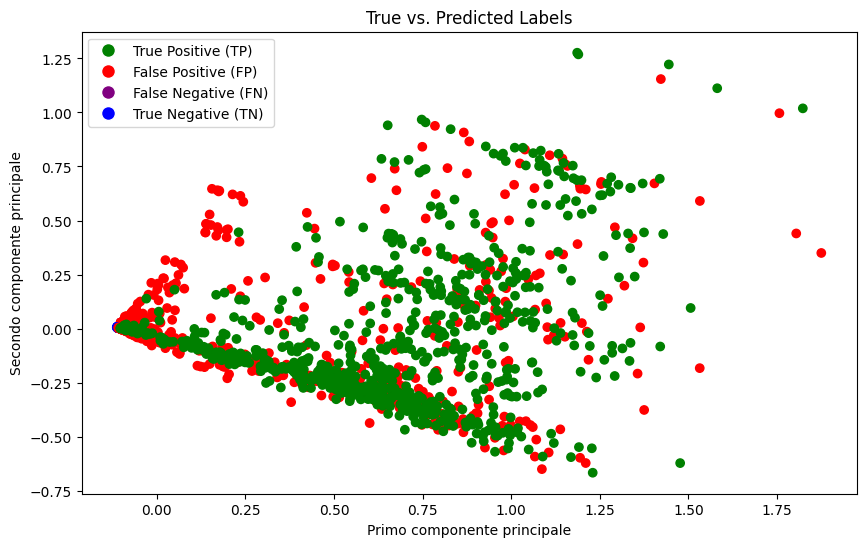

nu: 0.1, kernel: poly
Precision: 0.0971, Recall: 1.0000, F1 Score: 0.1770
------------------------------


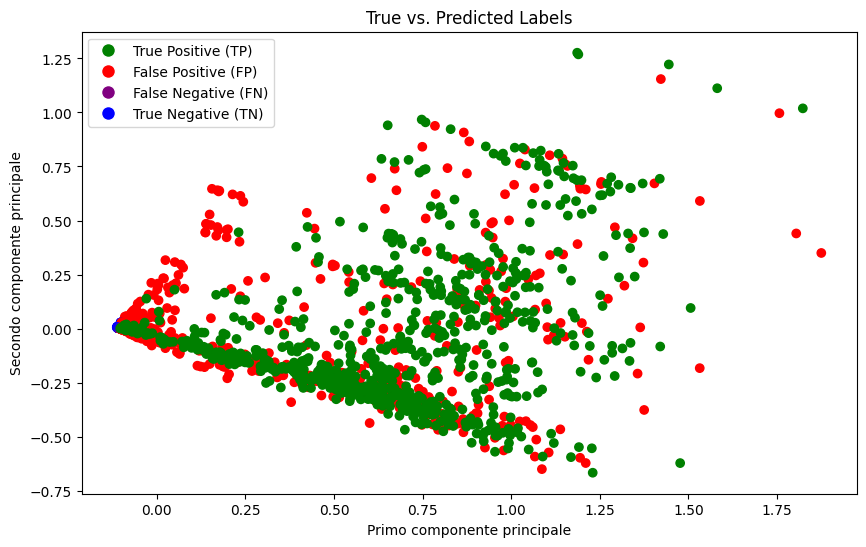

nu: 0.25, kernel: poly
Precision: 0.1213, Recall: 0.9987, F1 Score: 0.2163
------------------------------


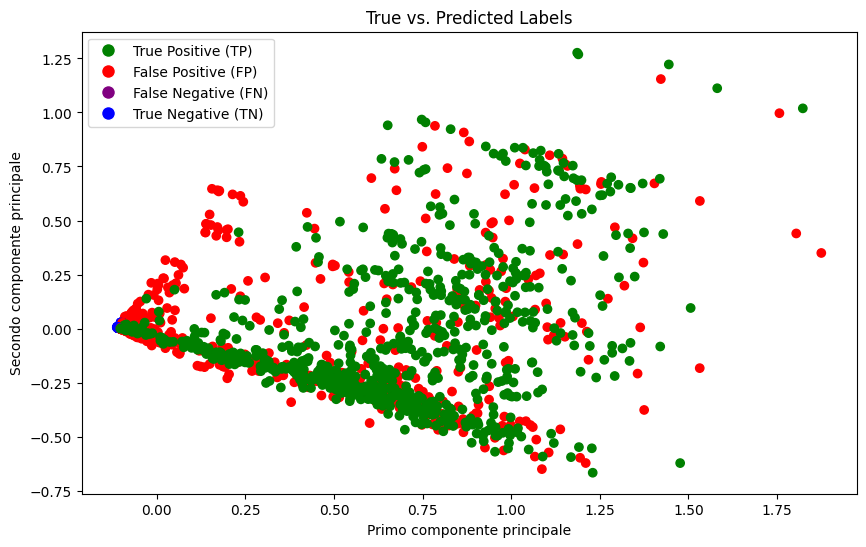

nu: 0.5, kernel: poly
Precision: 0.1942, Recall: 0.9947, F1 Score: 0.3250
------------------------------


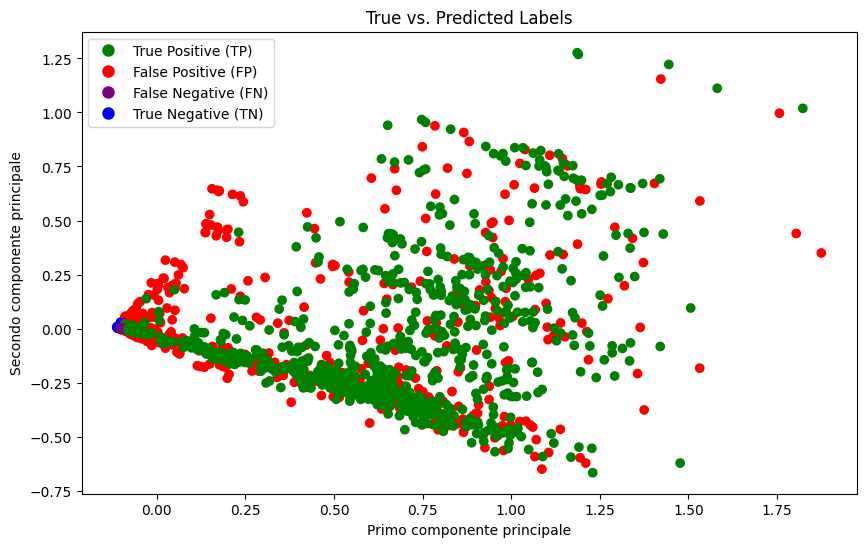

nu: 0.9, kernel: poly
Precision: 0.5605, Recall: 0.9670, F1 Score: 0.7096
------------------------------


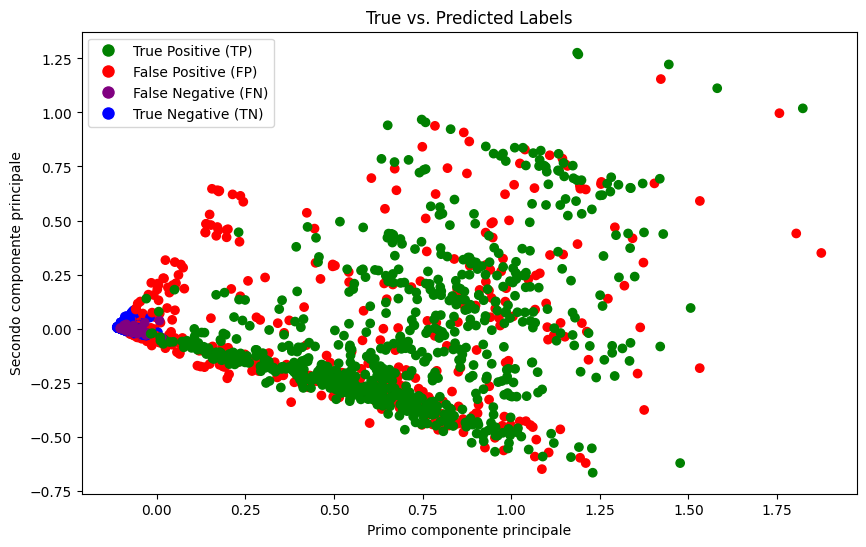

nu: 0.03, kernel: rbf
Precision: 0.0023, Recall: 0.0225, F1 Score: 0.0041
------------------------------


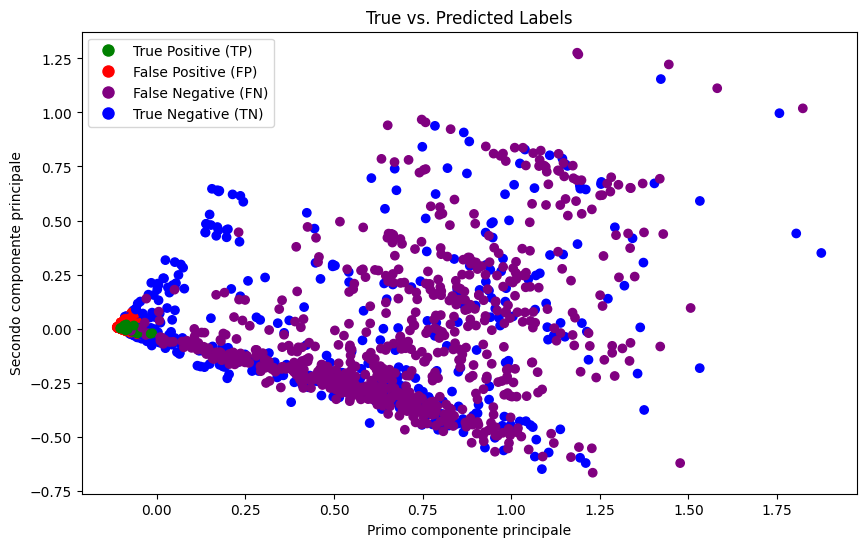

nu: 0.1, kernel: rbf
Precision: 0.0012, Recall: 0.0106, F1 Score: 0.0021
------------------------------


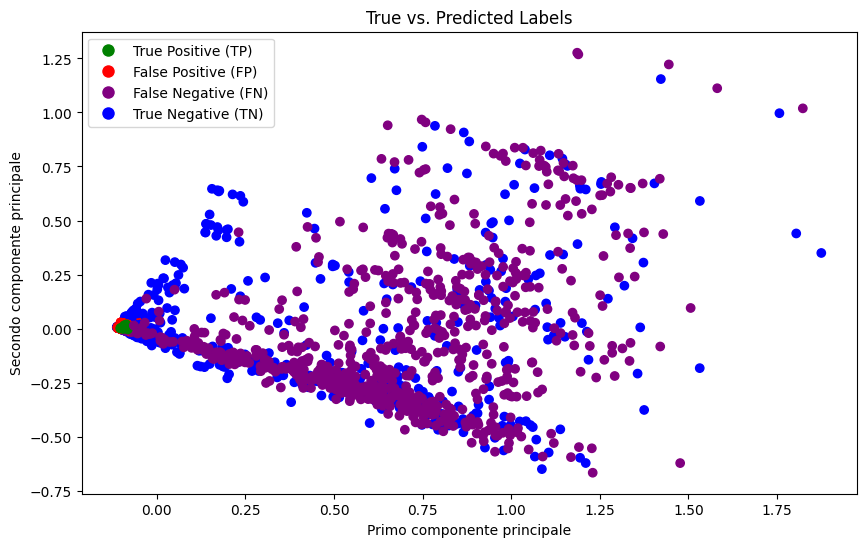

nu: 0.25, kernel: rbf
Precision: 0.0010, Recall: 0.0079, F1 Score: 0.0018
------------------------------


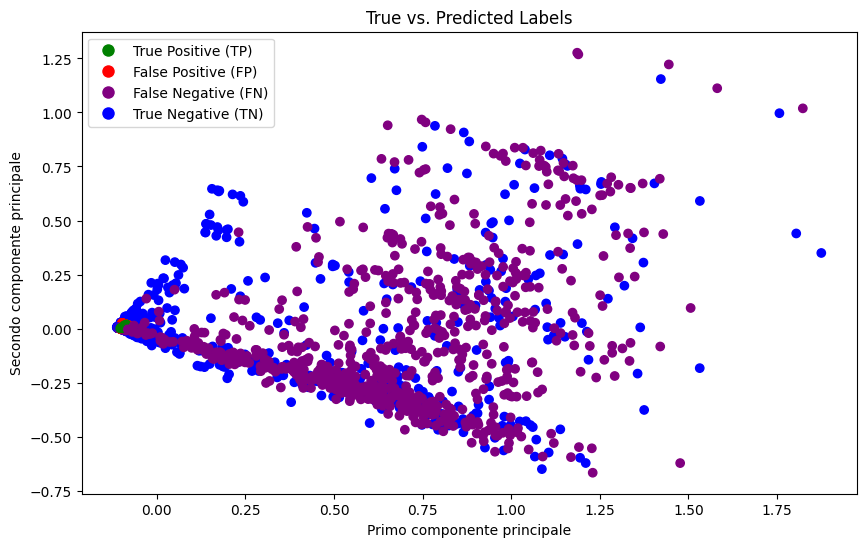

nu: 0.5, kernel: rbf
Precision: 0.0009, Recall: 0.0053, F1 Score: 0.0016
------------------------------


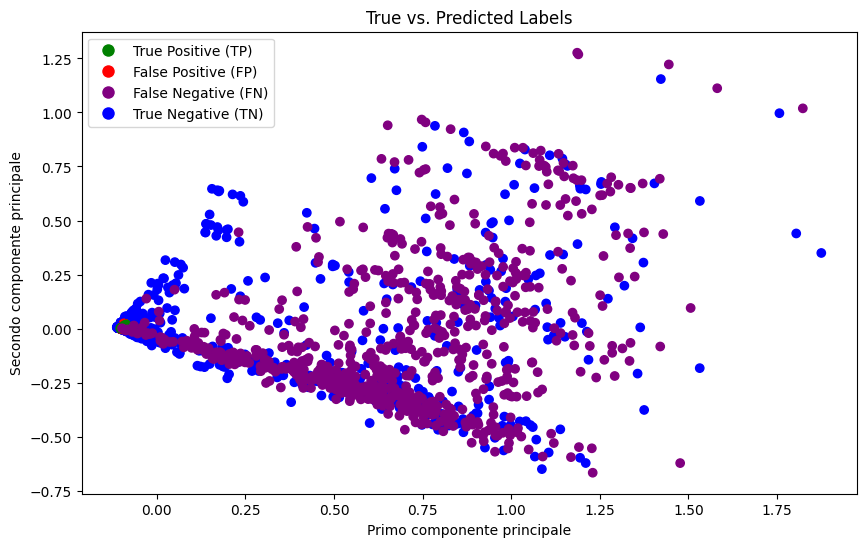

nu: 0.9, kernel: rbf
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
------------------------------


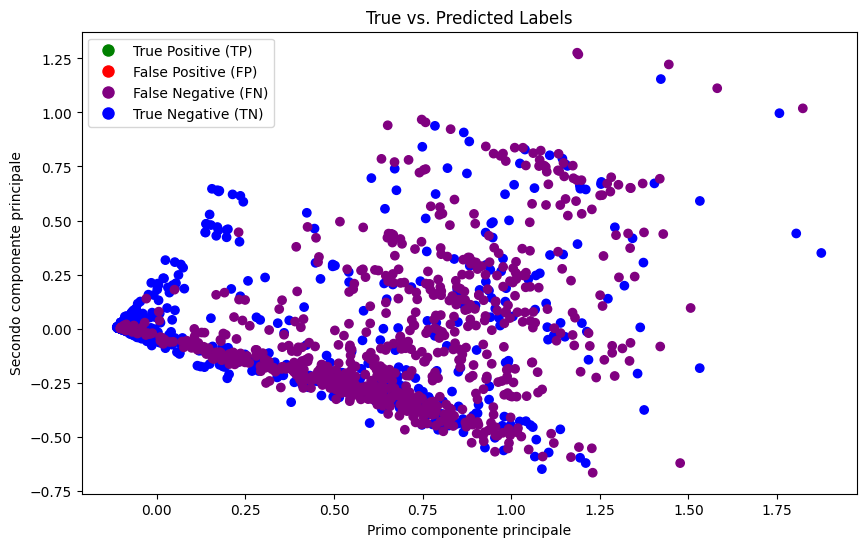

nu: 0.03, kernel: sigmoid
Precision: 0.0891, Recall: 1.0000, F1 Score: 0.1636
------------------------------


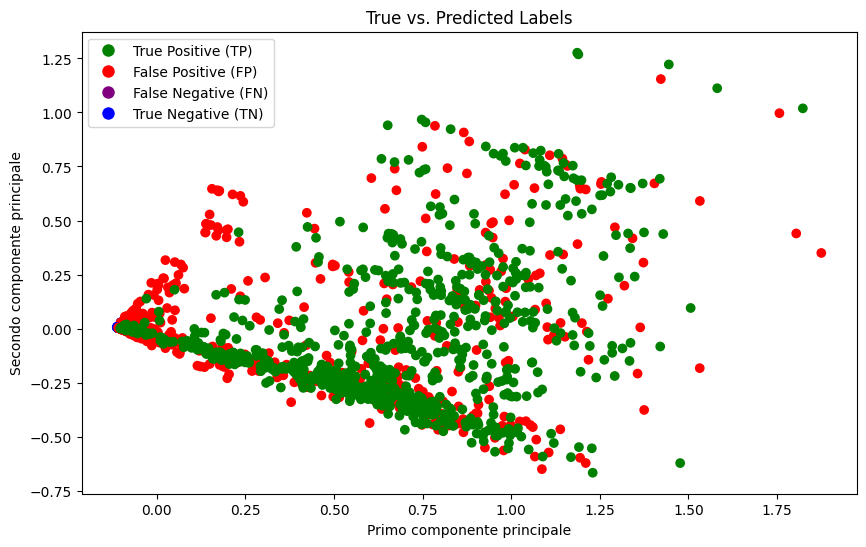

nu: 0.1, kernel: sigmoid
Precision: 0.0970, Recall: 1.0000, F1 Score: 0.1769
------------------------------


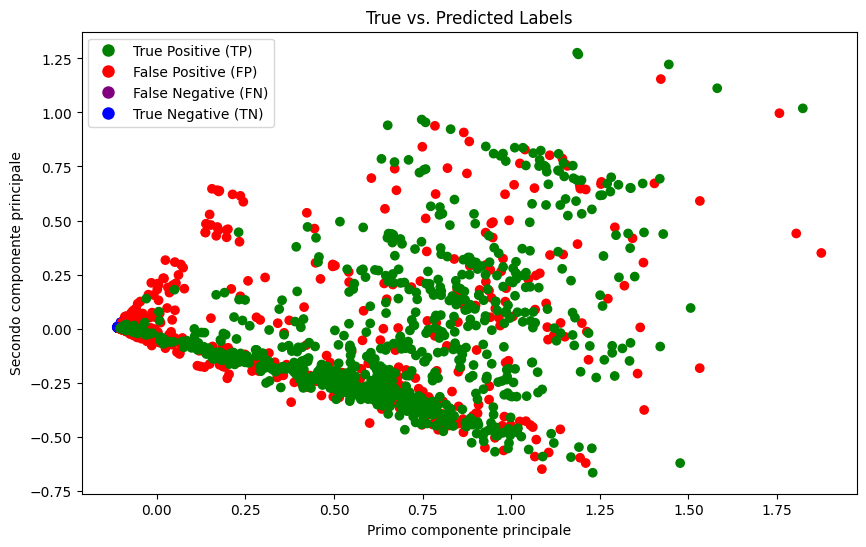

nu: 0.25, kernel: sigmoid
Precision: 0.1209, Recall: 0.9987, F1 Score: 0.2156
------------------------------


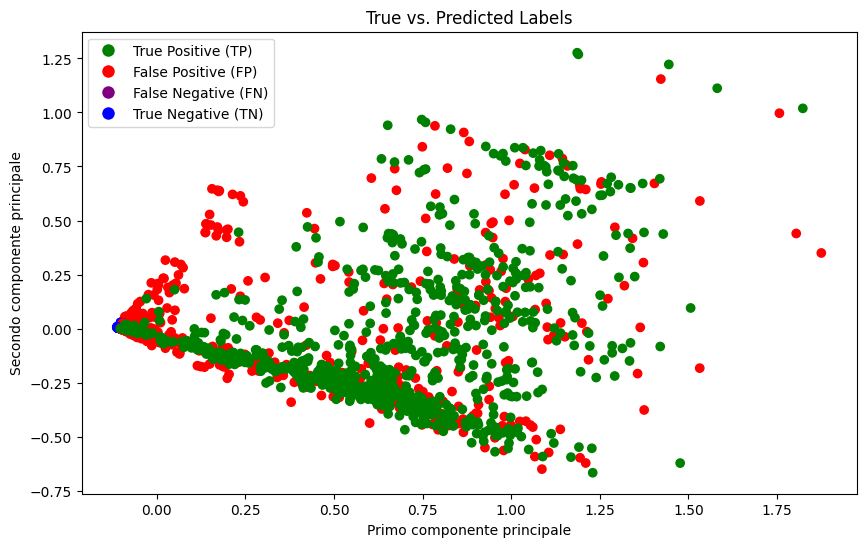

nu: 0.5, kernel: sigmoid
Precision: 0.1943, Recall: 0.9947, F1 Score: 0.3251
------------------------------


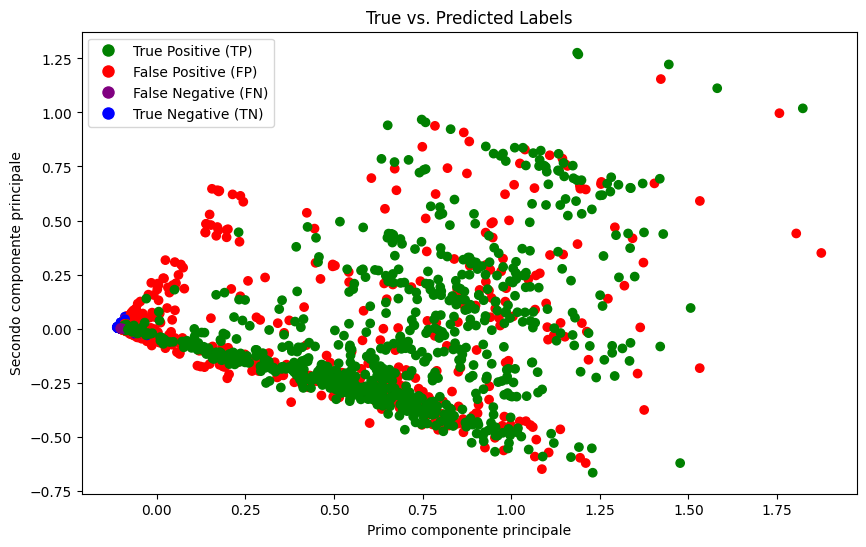

nu: 0.9, kernel: sigmoid
Precision: 0.5732, Recall: 0.9564, F1 Score: 0.7168
------------------------------


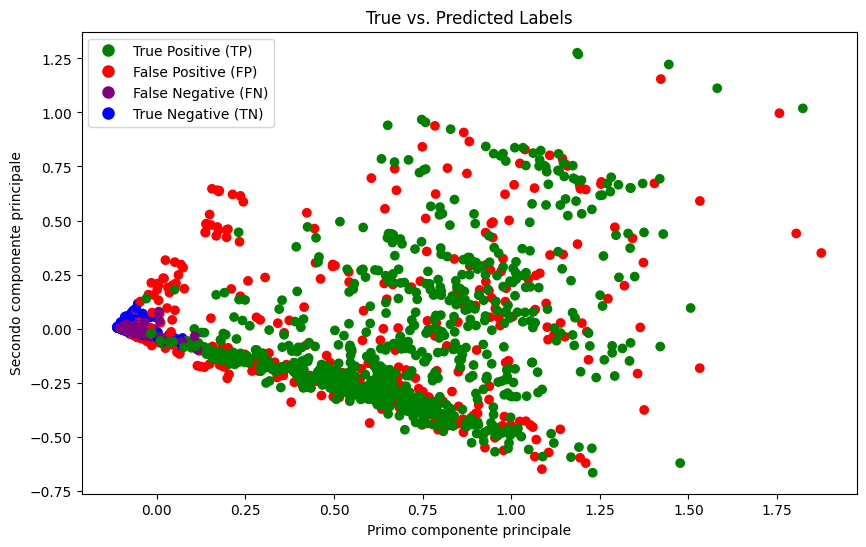

Best F1 Score: 0.7168316831683168
Best Hyperparameters: nu: 0.9, kernel: sigmoid


In [ ]:
params = {'nu': [0.03, 0.1, 0.25, 0.5, 0.9],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']} # precomputed is not present because it needs a square matrix

best_hyperparams = grid_search_ocsvm(train_set, valid_set, valid_labels.ravel(), params)

In [ ]:
# accorpate train and valid set since the validation is used only to search the hyperparameters
final_train_data = df_ready.iloc[:validation_end].values
final_train_labels = labels_df.iloc[:validation_end].astype(int).values

ocsvm = OneClassSVM(nu=0.9, kernel='sigmoid')
ocsvm.fit(final_train_data)

predicted_test_labels = ocsvm.predict(test_set)

In [ ]:
import plotly.express as px

def plot_label_differences_2d_plotly(test_data, true_labels, predicted_labels):
    # Perform PCA to reduce dimensionality to 2 dimensions
    pca = PCA(n_components=2)
    test_data_2d = pca.fit_transform(test_data)

    # Create a DataFrame to store data
    df = pd.DataFrame({
        'Prima componente principale': test_data_2d[:, 0],
        'Seconda componente principale': test_data_2d[:, 1],
        'True Labels': true_labels,
        'Predicted Labels': predicted_labels
    })

    legend_mapping = {
        (1, 1): 'True Positive',
        (0, 1): 'False Positive',
        (0, 0): 'True Negative',
        (1, 0): 'False Negative',
    }

    # Add a new column for legend labels based on the legend_mapping
    df['Legend Label'] = [legend_mapping[(true, pred)] for true, pred in zip(true_labels, predicted_labels)]

    # Create a color mapping for different categories
    color_mapping = {
      'True Positive': 'green',
      'False Positive': 'red',
      'False Negative': 'purple',
      'True Negative': 'blue',
    }

    # Add new columns for color and symbol based on the mappings
    df['Color'] = [color_mapping[label] for label in df['Legend Label']]

    # Create the interactive scatter plot using Plotly
    fig = px.scatter(df, x='Prima componente principale', y='Seconda componente principale',
                    color='Legend Label',  # Use the 'Legend Label' column for coloring
                    title='True vs. Predicted Labels',
                    labels={'Legend Label': 'Legend'},
                    color_discrete_map=color_mapping  # Specify the color mapping
                    )# Rename the color legend

    fig.update_traces(marker=dict(size=12))

    # Adjust the aspect ratio for a squared plot
    fig.update_layout(
        autosize=False,
        width=1500,  # Adjust the width to your preference
        height=1000,  # Adjust the height to your preference
        xaxis_scaleanchor='y',
        yaxis_scaleanchor='x',
        xaxis=dict(scaleanchor='y', constrain='domain'),
        yaxis=dict(scaleanchor='x', constrain='domain'),
        legend_font_size=18
    )

    # Show the plot
    fig.show()

In [ ]:
def plot_label_differences_3d_plotly(test_data, true_labels, predicted_labels):
    # Perform PCA to reduce dimensionality to 3 dimensions
    pca = PCA(n_components=3)
    test_data_3d = pca.fit_transform(test_data)

    # Create a DataFrame to store data
    df = pd.DataFrame({
        'Prima componente principale': test_data_3d[:, 0],
        'Seconda componente principale': test_data_3d[:, 1],
        'Terza componente principale': test_data_3d[:, 2],
        'True Labels': true_labels,
        'Predicted Labels': predicted_labels
    })

    legend_mapping = {
        (1, 1): 'True Positive',
        (0, 1): 'False Positive',
        (0, 0): 'True Negative',
        (1, 0): 'False Negative',
    }

    # Add a new column for legend labels based on the legend_mapping
    df['Legend Label'] = [legend_mapping[(true, pred)] for true, pred in zip(true_labels, predicted_labels)]

    # Create a color mapping for different categories
    color_mapping = {
      'True Positive': 'green',
      'False Positive': 'red',
      'False Negative': 'purple',
      'True Negative': 'blue',
    }

    # Add new columns for color and symbol based on the mappings
    df['Color'] = [color_mapping[label] for label in df['Legend Label']]

    # Create the interactive scatter plot using Plotly
    fig = px.scatter_3d(df, x='Prima componente principale', y='Seconda componente principale', z='Terza componente principale',
                        color='Legend Label',  # Use the 'Legend Label' column for coloring
                        title='True vs. Predicted Labels (3D)',
                        labels={'Legend Label': 'Legend'},
                        color_discrete_map=color_mapping  # Specify the color mapping
                        )

    fig.update_traces(marker=dict(size=5))

    # Adjust the aspect ratio for a squared plot
    fig.update_layout(
        autosize=False,
        width=1200,  # Adjust the width to your preference
        height=1000,  # Adjust the height to your preference
        legend_font_size=18
    )

    # Show the plot
    fig.show()

In [ ]:
# rappresentazione della soluzione in tre dimensioni

predicted_test_labels[predicted_test_labels==-1] = 0
predicted_test_labels = predicted_test_labels.astype(bool)
plot_label_differences_3d_plotly(test_set, test_labels.ravel(), predicted_test_labels)

precision, recall, f1 = calculate_metrics(test_labels, predicted_test_labels)
print("Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}".format(precision, recall, f1))
print('-' * 30)

Precision: 0.3313, Recall: 0.2908, F1 Score: 0.3097
------------------------------
